In [15]:
import math
import time
import sys
import os
import random
import glob
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import PIL.ImageOps 
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils
from torch.utils.data import DataLoader, Dataset

use_gpu = torch.cuda.is_available()

In [16]:
DATA_DIR = "data/"
trn_dir = f'{DATA_DIR}/train'
tst_dir = f'{DATA_DIR}/test'

sz = 64
batch_size = 64

In [17]:
os.listdir(DATA_DIR)

['train', 'test']

In [18]:
trn_fnames = glob(f'{trn_dir}/*/*.bmp')
trn_fnames[:3]

['data//train/thermal/1821i.bmp',
 'data//train/thermal/1823i.bmp',
 'data//train/thermal/1802i.bmp']

(-0.5, 359.5, 269.5, -0.5)

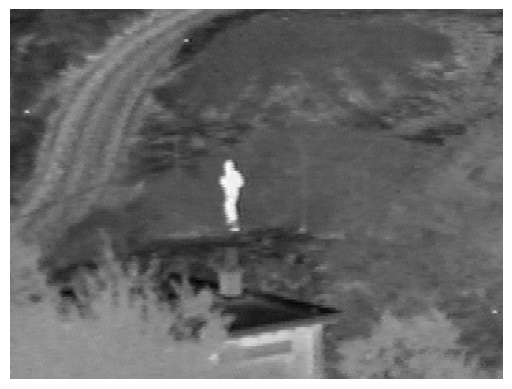

In [19]:
img = plt.imread(trn_fnames[1])
plt.imshow(img,cmap='gray');
plt.axis('off')


In [20]:
train_ds = datasets.ImageFolder(trn_dir)

tfms = transforms.Compose([
    transforms.Resize((sz, sz//2)),  # PIL Image
#     transforms.Grayscale(), 
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.44 , 0.053, 0.062], [0.076, 0.079, 0.085])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
test_ds = datasets.ImageFolder(tst_dir, transform=tfms)

len(train_ds), len(test_ds)

(64, 64)

In [21]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,  shuffle=True, num_workers=8)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=8)

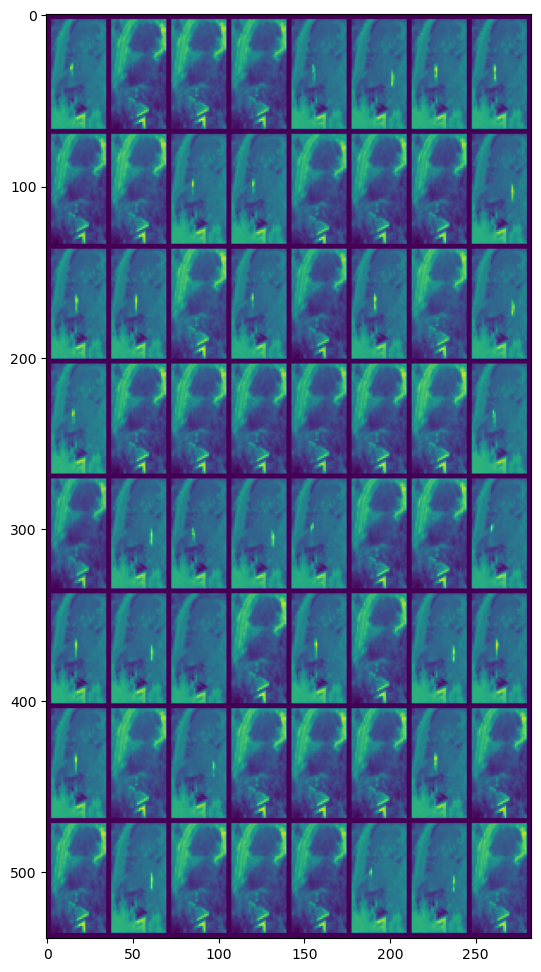

In [26]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
plt.imshow(out[-1])

In [28]:

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1_1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),

            nn.LeakyReLU(0.1, inplace=True),

        )
        self.conv1_2 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),

            nn.LeakyReLU(0.1, inplace=True),

        )
        self.conv1_3 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),

            nn.LeakyReLU(0.1, inplace=True),

        )
        
        self.conv2_1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv2_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv2_3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.conv3_1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)

        )   
        self.conv3_2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)

        )   
        
        self.conv3_3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)

        )   
                
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),

            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )   
           
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(128*2, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),

            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )   

        self.fc1 = nn.Linear(256*8*4*2, 2)

        
        
    def forward(self, x, y, z):
        outx = self.conv1_1(x)
        outx = self.conv2_1(outx)
        outx = self.conv3_1(outx)
        outx = self.conv4(outx)
        outx = outx.view(outx.size(0), -1)
        
        outy = self.conv1_2(y)
        outy = self.conv2_2(outy)
        outy = self.conv3_2(outy)

        
        outz = self.conv1_3(z)
        outz = self.conv2_3(outz)
        outz = self.conv3_3(outz)
        
        oyz=torch.cat([outy,outz],1)
        
        oyz = self.conv5(oyz)
        oyz = oyz.view(oyz.size(0), -1)
                
        oo=torch.cat([outx,oyz],1)
             
        out = self.fc1(oo)
           
        return out

In [31]:
model = CNN()

if use_gpu:
    
    model = model.cuda()
    model.cuda()
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))

model

CNN(
  (conv1_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv1_2): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv1_3): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): MaxPool

In [30]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [32]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

In [34]:
a = time.time()
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        

        
        inputs = to_var(inputs)
#         inputs2 = to_var(inputs2)
#         inputs3 = to_var(inputs3)
        targets = to_var(targets)
        
        inputs1=inputs[:,0,:,:]
        inputs1=inputs1.resize(inputs1.shape[0],1,64,32)
        inputs2=inputs[:,1,:,:]
        inputs2=inputs1.resize(inputs2.shape[0],1,64,32)
        inputs3=inputs[:,2,:,:]
        inputs3=inputs1.resize(inputs3.shape[0],1,64,32)
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs1,inputs2,inputs3)

        # loss
        loss = criterion(outputs, targets)
        losses += [loss.item()]


        # backward pass
        loss.backward()

        
        # update parameters
        optimizer.step()

        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.data[0]))
            
b = time.time()
print('Total Time of Training {:.1000}s'.format(b - a))

Total Time of Training 377.82075214385986328125s


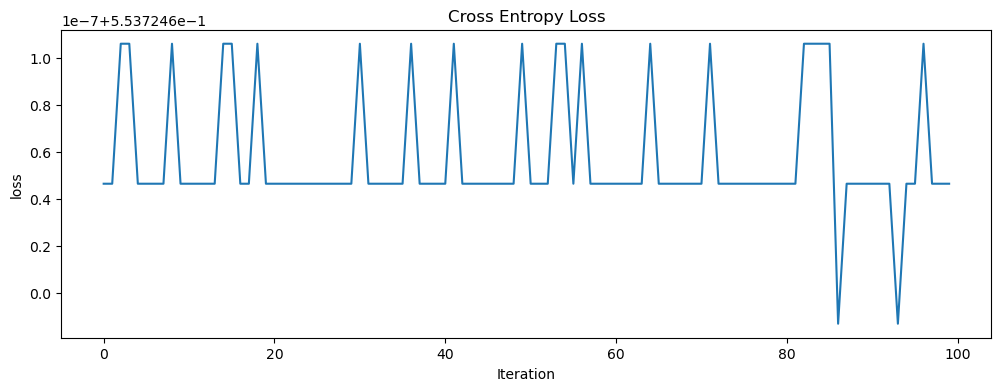

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');

In [36]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
#         targets = to_var(targets)
        
        inputs1=inputs[:,0,:,:]
        inputs1=inputs1.resize(inputs1.shape[0],1,64,32)
        inputs2=inputs[:,1,:,:]
        inputs2=inputs1.resize(inputs2.shape[0],1,64,32)
        inputs3=inputs[:,2,:,:]
        inputs3=inputs1.resize(inputs3.shape[0],1,64,32)
        
        outputs = model(inputs1,inputs2,inputs3)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
        
    zz=len(dataloader.dataset)
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))
    print('corrects: {:.2f}'.format(corrects))
    print('Toatal: {:.2f}'.format(zz))
    

In [38]:
evaluate_model(model, train_dl)
evaluate_model(model, test_dl)
torch.save(model.state_dict(), 'ECNN_network_wights_1.pth')

/tmp/ipykernel_218878/2255835562.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 84.38
corrects: 54.00
Toatal: 64.00
accuracy: 84.38
corrects: 54.00
Toatal: 64.00
